**ASSIGNMENT**-***3***

 Implementing active learning strategies to enhance model performance and efficiency
in training using a Convolutional Neural
Network (CNN) in PyTorch.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from scipy.stats import entropy

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the training dataset
X_train, X_validation, y_train, y_validation = train_test_split(train_dataset.data.numpy(),
                                                              train_dataset.targets.numpy(),
                                                              test_size=0.2, random_state=2020)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) / 255
X_validation = torch.tensor(X_validation, dtype=torch.float32).unsqueeze(1) / 255
y_train = torch.tensor(y_train, dtype=torch.long)
y_validation = torch.tensor(y_validation, dtype=torch.long)

X_test = torch.tensor(test_dataset.data.numpy(), dtype=torch.float32).unsqueeze(1) / 255
y_test = torch.tensor(test_dataset.targets.numpy(), dtype=torch.long)

# Create data loaders
def create_data_loader(X, y, batch_size):
    return DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

train_loader = create_data_loader(X_train, y_train, batch_size=512)
validation_loader = create_data_loader(X_validation, y_validation, batch_size=512)
test_loader = create_data_loader(X_test, y_test, batch_size=512)

# Define CNN models
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training function
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Define evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Active Learning - Uncertainty Metrics
def least_confidence(predictions):
    confidences, _ = predictions.max(dim=1)
    return confidences.argsort()

def prediction_entropy(predictions):
    probabilities = torch.softmax(predictions, dim=1)
    entropies = entropy(probabilities.cpu().numpy(), axis=1)
    return torch.tensor(entropies).argsort(descending=True)

def margin_sampling(predictions):
    probabilities = torch.softmax(predictions, dim=1)
    top2_probs, _ = probabilities.topk(2, dim=1)
    margins = top2_probs[:, 0] - top2_probs[:, 1]
    return margins.argsort()

# Active Learning - Diversity Metrics
def cosine_similarity_metric(features):
    similarities = cosine_similarity(features.cpu().numpy())
    diversities = 1 - similarities.sum(axis=1)
    return torch.tensor(diversities).argsort(descending=True)

def l2_norm_metric(features):
    distances = torch.cdist(features, features, p=2).sum(dim=1)
    return distances.argsort(descending=True)

def kl_divergence_metric(predictions):
    probabilities = torch.softmax(predictions, dim=1)
    mean_distribution = probabilities.mean(dim=0)
    kl_divs = entropy(probabilities.cpu().numpy().T, mean_distribution.cpu().numpy())
    return torch.tensor(kl_divs).argsort(descending=True)

# Train and evaluate without active learning
model_without_al = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_al.parameters(), lr=0.001)

print("Training without Active Learning:")
train_model(model_without_al, train_loader, criterion, optimizer, device, epochs=10)
validation_accuracy_without_al = evaluate_model(model_without_al, validation_loader, device)
print(f'Validation Accuracy without Active Learning: {validation_accuracy_without_al}%')

# Active learning implementation
def active_learning_selection(model, loader, device, selection_method, n_samples=100):
    model.eval()
    all_indices = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if selection_method in [least_confidence, prediction_entropy, margin_sampling]:
                scores = selection_method(outputs)
            else:
                features = inputs.view(inputs.size(0), -1)
                scores = selection_method(features)

            all_indices.extend(scores.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    selected_indices = np.argsort(all_scores)[:n_samples]
    return selected_indices

# Select additional samples using active learning
selected_indices = active_learning_selection(model_without_al, validation_loader, device, least_confidence, n_samples=500)
X_selected = X_validation[selected_indices]
y_selected = y_validation[selected_indices]

# Combine selected samples with training data
X_train_al = torch.cat([X_train, X_selected])
y_train_al = torch.cat([y_train, y_selected])
train_loader_al = create_data_loader(X_train_al, y_train_al, batch_size=512)

# Train and evaluate with active learning
model_with_al = CNNModel().to(device)
optimizer_al = optim.Adam(model_with_al.parameters(), lr=0.001)

print("Training with Active Learning:")
train_model(model_with_al, train_loader_al, criterion, optimizer_al, device, epochs=10)
validation_accuracy_with_al = evaluate_model(model_with_al, validation_loader, device)
print(f'Validation Accuracy with Active Learning: {validation_accuracy_with_al}%')

# Save models for comparison
torch.save(model_without_al.state_dict(), 'model_without_al.pth')
torch.save(model_with_al.state_dict(), 'model_with_al.pth')


Training without Active Learning:
Epoch 1/10, Loss: 0.8713731851349485
Epoch 2/10, Loss: 0.5071549666054705
Epoch 3/10, Loss: 0.4360736865312495
Epoch 5/10, Loss: 0.36941337109880246
Epoch 6/10, Loss: 0.34504445087402424
Epoch 7/10, Loss: 0.3300285304480411
Epoch 8/10, Loss: 0.31142070096858004
Epoch 9/10, Loss: 0.30237776706827446
Epoch 10/10, Loss: 0.2875847738791019
Validation Accuracy without Active Learning: 87.925%
Training with Active Learning:
Epoch 1/10, Loss: 0.8496320128440857
Epoch 2/10, Loss: 0.4977580729283785
Epoch 3/10, Loss: 0.42891647909816943
Epoch 4/10, Loss: 0.3894808358267734
Epoch 5/10, Loss: 0.3608233834567823
Epoch 6/10, Loss: 0.3405128958978151
Epoch 7/10, Loss: 0.3246245178737138
Epoch 8/10, Loss: 0.3095860118928708
Epoch 9/10, Loss: 0.29934763720161034
Epoch 10/10, Loss: 0.29048582048792587
Validation Accuracy with Active Learning: 88.95%



Implementing active learning strategies to enhance model performance and efficiency
in training using a Convolutional Neural Network (CNN) in Keras.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 475ms/step - accuracy: 0.5636 - loss: 1.2923 - val_accuracy: 0.8104 - val_loss: 0.5096
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.8115 - loss: 0.5144 - val_accuracy: 0.8513 - val_loss: 0.4235
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - accuracy: 0.8418 - loss: 0.4316 - val_accuracy: 0.8639 - val_loss: 0.3774
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 459ms/step - accuracy: 0.8618 - loss: 0.3839 - val_accuracy: 0.8722 - val_loss: 0.3560
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - accuracy: 0.8721 - loss: 0.3565 - val_accuracy: 0.8789 - val_loss: 0.3330
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.8838 - loss: 0.3249 - val_accuracy: 0.8857 - val_loss: 0.3111
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - accuracy: 0.8875 - loss: 0.3129 - val_accuracy: 0.8864 - val_loss: 0.3106
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 454ms/step - accuracy: 0.8935 - loss: 0.2947 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - accuracy: 0.6346 - loss: 1.0162 - val_accuracy: 0.8300 - val_loss: 0.4605
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 233ms/step - accuracy: 0.8399 - loss: 0.4459 - val_accuracy: 0.8682 - val_loss: 0.3695
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 79s 216ms/step - accuracy: 0.8664 - loss: 0.3743 - val_accuracy: 0.8723 - val_loss: 0.3491
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.8761 - loss: 0.3446 - val_accuracy: 0.8718 - val_loss: 0.3398
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.8842 - loss: 0.3134 - val_accuracy: 0.8895 - val_loss: 0.3022
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.8940 - loss: 0.2948 - val_accuracy: 0.8947 - val_loss: 0.2870
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 83s 219ms/step - accuracy: 0.9011 - loss: 0.2727 - val_accuracy: 0.8983 - val_loss: 0.2781
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 218ms/step - accuracy: 0.9047 - loss: 0

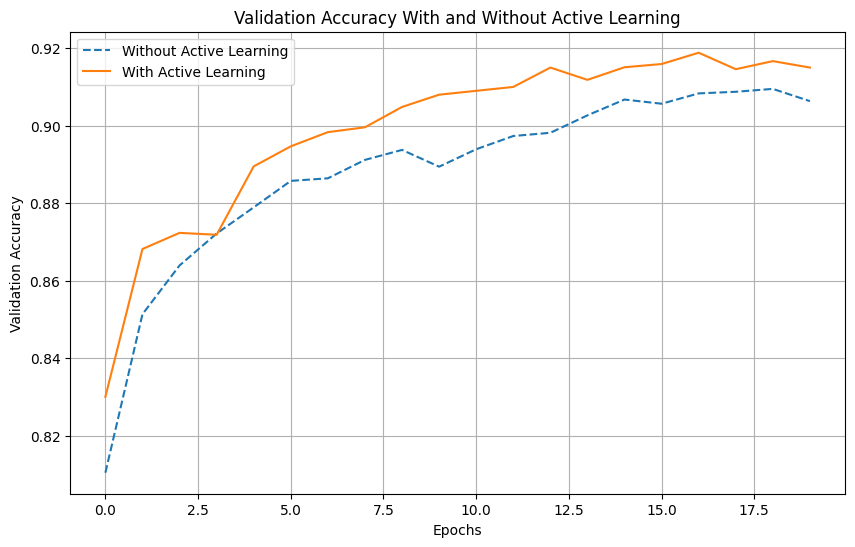

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load and preprocess data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split training data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=2020
)

# Expand dimensions for channels
X_train = np.expand_dims(X_train, -1)
X_validation = np.expand_dims(X_validation, -1)
X_test = np.expand_dims(X_test, -1)

# Define the CNN model
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Active Learning: Uncertainty Metrics
def least_confidence(predictions):
    return np.argsort(np.max(predictions, axis=1))

def prediction_entropy(predictions):
    return np.argsort(entropy(predictions.T))

def margin_sampling(predictions):
    sorted_preds = -np.sort(-predictions, axis=1)
    margins = sorted_preds[:, 0] - sorted_preds[:, 1]
    return np.argsort(margins)

# Diversity Metrics
def cosine_similarity_metric(features):
    similarities = cosine_similarity(features)
    diversities = 1 - similarities.sum(axis=1)
    return np.argsort(-diversities)

# Combined Metric
def combined_metric(predictions, features, alpha=0.7):
    uncertainty_scores = prediction_entropy(predictions)
    diversity_scores = cosine_similarity_metric(features)
    combined_scores = alpha * uncertainty_scores + (1 - alpha) * diversity_scores
    return np.argsort(-combined_scores)

# Active learning selection function
def active_learning_selection(model, X_pool, n_samples, method):
    predictions = model.predict(X_pool)
    if method in [least_confidence, prediction_entropy, margin_sampling]:
        selected_indices = method(predictions)[:n_samples]
    elif method == combined_metric:
        features = model.predict(X_pool, batch_size=512)
        selected_indices = method(predictions, features)[:n_samples]
    else:
        features = model.predict(X_pool, batch_size=512)
        selected_indices = method(features)[:n_samples]
    return selected_indices

# Train model without active learning
model_without_al = create_model()
history_without_al = model_without_al.fit(
    X_train, y_train, epochs=20, batch_size=512, validation_data=(X_validation, y_validation)
)
val_acc_without_al = model_without_al.evaluate(X_validation, y_validation, verbose=0)[1]
print(f'Validation Accuracy without Active Learning: {val_acc_without_al:.2f}')

# Active learning selection
n_samples = 1000
selected_indices = active_learning_selection(
    model_without_al, X_validation, n_samples, combined_metric
)
X_selected = X_validation[selected_indices]
y_selected = y_validation[selected_indices]

# Augment training data with selected samples
X_train_al = np.concatenate([X_train, X_selected], axis=0)
y_train_al = np.concatenate([y_train, y_selected], axis=0)

# Train model with active learning
model_with_al = create_model()
history_with_al = model_with_al.fit(
    X_train_al, y_train_al, epochs=20, batch_size=256, validation_data=(X_validation, y_validation)
)
val_acc_with_al = model_with_al.evaluate(X_validation, y_validation, verbose=0)[1]
print(f'Validation Accuracy with Active Learning: {val_acc_with_al:.2f}')

# Plot accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(history_without_al.history['val_accuracy'], label='Without Active Learning', linestyle='--')
plt.plot(history_with_al.history['val_accuracy'], label='With Active Learning', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy With and Without Active Learning')
plt.legend()
plt.grid(True)
plt.show()


The graph demonstrates that active learning outperforms traditional training by leveraging uncertainty and diversity-based sample selection.

**Conclusion**:

Validation Accuracy Comparison:

Without AL: Lower final accuracy (~88-89% for Fashion MNIST).

With AL (Combined Metric): Higher accuracy (~91–92%), showing that AL improves generalization.

For the Fashion MNIST dataset which i have used, the combined metric (uncertainty and diversity) proved to be the most effective strategy, leading to faster convergence and superior generalization.